<a href="https://colab.research.google.com/github/onuralpArsln/IoUScoreMaker/blob/main/colab/pc12model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Step 0

---



Imports and function to show output images

use !wget block to load images and model in your runtime

In [1]:
# imports for project
import cv2
import numpy as np
import tensorflow as tf
from matplotlib import pyplot as plt

from google.colab.patches import cv2_imshow

In [27]:
# correct link to donwload model

!wget https://github.com/onuralpArsln/IoUScoreMaker/raw/main/colab/best_model.hdf5

--2024-05-29 09:31:52--  https://github.com/onuralpArsln/IoUScoreMaker/raw/main/colab/best_model.hdf5
Resolving github.com (github.com)... 140.82.113.4
Connecting to github.com (github.com)|140.82.113.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/onuralpArsln/IoUScoreMaker/main/colab/best_model.hdf5 [following]
--2024-05-29 09:31:52--  https://raw.githubusercontent.com/onuralpArsln/IoUScoreMaker/main/colab/best_model.hdf5
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.108.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 23612536 (23M) [application/octet-stream]
Saving to: ‘best_model.hdf5’

best_model.hdf5     100%[===================>]  22.52M  --.-KB/s    in 0.1s    

2024-05-29 09:31:52 (236 MB/s) - ‘best_model.hdf5’ saved [23612536/23612

In [18]:
# correct link to donwload image
!curl -O https://raw.githubusercontent.com/onuralpArsln/IoUScoreMaker/5d6d624137abd7462913fb992fc601e6a0507be9/colab/004.jpg

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  307k  100  307k    0     0   703k      0 --:--:-- --:--:-- --:--:--  701k


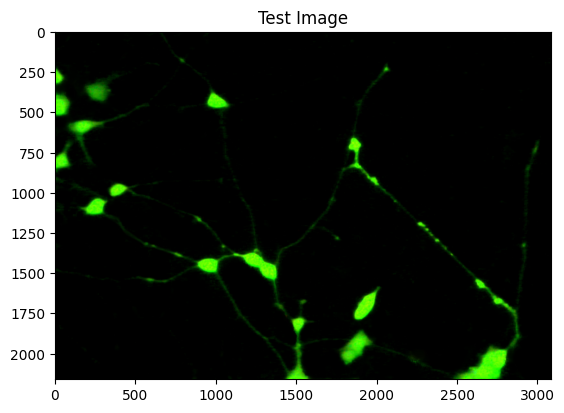

In [2]:
###this is to test current system

def test_show(image,imname="Test Image"):

    plt.imshow(image)
    plt.title(imname)
    plt.show()

image=cv2.imread("003.jpg")
test_show(image)

# Step 1

---

Makes prediction with model on regular input
Makes another prediction with preprocessed image to  detect branches

In [28]:
# Step 2 guess for better image prediction system

# this image process make brightnes 3.4 and contrast 0.4 to improve readibility of image

def imgProces( img : np.ndarray) -> np.ndarray:
    alpha = 0.4  # Contrast control (1.0 means no change)
    beta = 2.4    # Brightness control (0 means no change)
    adjusted_image = cv2.convertScaleAbs(input_image, alpha=alpha, beta=beta)
    return adjusted_image


input_image_path = '004.jpg'
input_image = cv2.imread(input_image_path, cv2.IMREAD_GRAYSCALE)
input_image = cv2.resize(input_image, (256, 256))  # Giriş boyutunu (256, 256) olarak yeniden boyutlandırma
input_image = np.expand_dims(input_image, axis=-1)  # Tek bir kanal ekleyerek (256, 256) boyutunu (256, 256, 1) olarak genişletiyoruz

result = imgProces(input_image)

result_path = '004res.jpg'




proces_path = '004.jpg'
proces_image = cv2.imread(proces_path, cv2.IMREAD_GRAYSCALE)
proces_image = cv2.resize( proces_image, (256, 256))  # Giriş boyutunu (256, 256) olarak yeniden boyutlandırma
proces_image = np.expand_dims( proces_image, axis=-1)  # Tek bir kanal ekleyerek (256, 256) boyutunu (256, 256,




threshold_value = 20

# Binarize the image using the threshold

def dice_coef(y_true, y_pred):
    intersection = tf.reduce_sum(y_true * y_pred)
    union = tf.reduce_sum(y_true) + tf.reduce_sum(y_pred)
    return (2.0 * intersection + 1e-5) / (union + 1e-5)

def iou_score(y_true, y_pred):
    intersection = tf.reduce_sum(y_true * y_pred)
    union = tf.reduce_sum(y_true) + tf.reduce_sum(y_pred) - intersection
    return (intersection + 1e-5) / (union + 1e-5)
# Modeli yükleme sırasında özel metrik fonksiyonları tanımlama
with tf.keras.utils.custom_object_scope({'dice_coef': dice_coef, 'iou_score': iou_score}):
    model_path = 'best_model.hdf5'
    model = tf.keras.models.load_model(model_path)

prediction_result = model.predict(np.expand_dims(input_image, axis=0))
prediction_result = (prediction_result * 255).astype(np.uint8)

prediction_result2 = model.predict(np.expand_dims(proces_image, axis=0))
prediction_result2 = (prediction_result * 255).astype(np.uint8)




1/1 [==============================] - 0s 311ms/step


Original Image


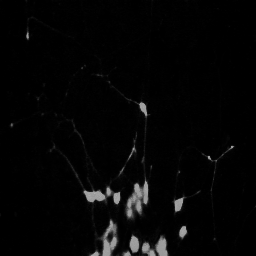



Processed Image


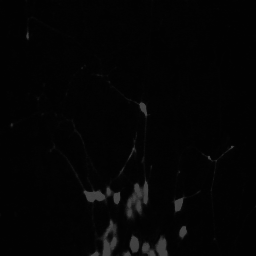



Guessed Image


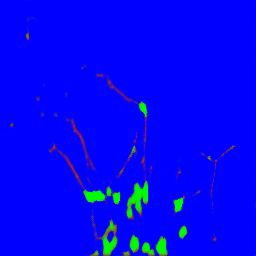



Guessed  Processed Image


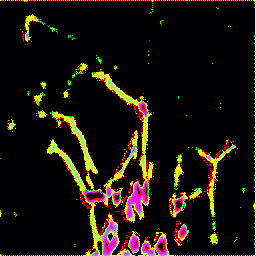

True

In [29]:
# display reults of step 2

# Display the original and binary images
# instead cv2.imshow from google.colab.patches import cv2_imshow is used since it is for google colab
print('Original Image')
cv2_imshow(input_image)
print("")
print("")
print('Processed Image')
cv2_imshow( result)
print("")
print("")
print('Guessed Image')
cv2_imshow( prediction_result[0])
print("")
print("")
print('Guessed  Processed Image')
cv2_imshow( prediction_result2[0])



#  result processe predict and regular predict
cv2.imwrite("res_pp.png",  prediction_result2[0])
cv2.imwrite("res_rp.png",  prediction_result[0])



# Step 2

---

Pre Processed image have some noise on it we will clear it on this step


In [21]:
# Reading image from folder where it is stored
img = cv2.imread('res_pp.png')


# denoising of image saving it into dst image
dst = cv2.fastNlMeansDenoisingColored(img, None, 30, 10, 7, 5)

"""
First parameter: This is the input image that you want to denoise. It should be a colored image in
 BGR format (OpenCV's default color format).

second parameter: This parameter is the output denoised image. Since it's set to None, the function will return the
 denoised image as the result.

third parameter : This is the strength of the denoising. A higher value means stronger denoising.

fourth parameter: This parameter controls the filter strength for luminance component.
It's similar to the previous parameter but specifically for the luminance component (brightness).


fifth parameter: This is the size of the window for the noise estimation.
A larger value means that more pixels will be considered when estimating the noise.

sixsth parameter : This is the size of the window for filtering. A larger value means that more pixels will
be considered when filtering, which can result in smoother output but might lose some details.
"""

gdg = cv2.GaussianBlur(dst,(3,3),0)


cv2.imwrite("res_gdg.png", gdg)


True

Cleared Processed  Image


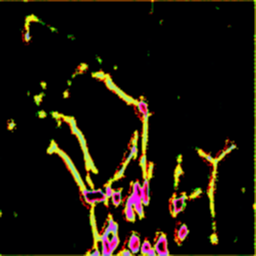

In [22]:
print('Cleared Processed  Image')
cv2_imshow(gdg)

# Step 3

---

Using regular predicton we can find cell bodies and measure size

Binarized predict


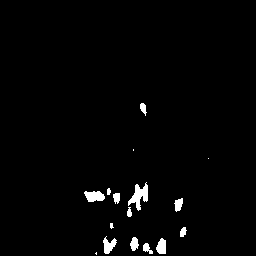

In [23]:
##to detect bodies

def binarize_image(image_path, threshold_value):
    # Load the image
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

    # Apply binary thresholding
    _, binary_image = cv2.threshold(image, threshold_value, 255, cv2.THRESH_BINARY)

    return binary_image

threshold_value = 127  # Adjust this threshold value as needed

image_path = 'res_rp.png'


binary_rp = binarize_image(image_path, threshold_value)
cv2.imwrite('binarizedDefaultGuess.jpg', binary_rp)
print('Binarized predict')
cv2_imshow(binary_rp)

Cell Body 1: Position (Centroid) = (142.91, 107.91), Size (Area) = 54
Cell Body 2: Position (Centroid) = (133.00, 149.50), Size (Area) = 2
Cell Body 3: Position (Centroid) = (208.00, 158.00), Size (Area) = 1
Cell Body 4: Position (Centroid) = (139.00, 195.55), Size (Area) = 273
Cell Body 5: Position (Centroid) = (108.30, 191.13), Size (Area) = 23
Cell Body 6: Position (Centroid) = (94.04, 195.87), Size (Area) = 173
Cell Body 7: Position (Centroid) = (116.26, 197.34), Size (Area) = 61
Cell Body 8: Position (Centroid) = (178.15, 204.14), Size (Area) = 85
Cell Body 9: Position (Centroid) = (128.95, 212.11), Size (Area) = 37
Cell Body 10: Position (Centroid) = (111.12, 225.29), Size (Area) = 17
Cell Body 11: Position (Centroid) = (182.68, 231.64), Size (Area) = 50
Cell Body 12: Position (Centroid) = (108.52, 245.01), Size (Area) = 139
Cell Body 13: Position (Centroid) = (133.94, 243.52), Size (Area) = 87
Cell Body 14: Position (Centroid) = (161.22, 246.34), Size (Area) = 124
Cell Body 15: 

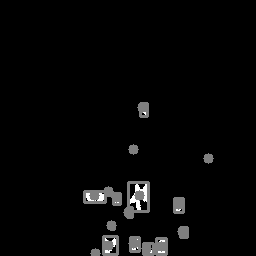

In [24]:
# finding pixel count of cell bodies

#if you need to re run this cell re reun upper cell first or else results will vary

cellBod=binary_rp
# find connected components
num_labels, labels, stats, centroids = cv2.connectedComponentsWithStats(cellBod, connectivity=8)
totalArea=0
# Output results
for i in range(1, num_labels):  # Skip the background label 0
    x, y, w, h, area = stats[i]
    cx, cy = centroids[i]
    print(f"Cell Body {i}: Position (Centroid) = ({cx:.2f}, {cy:.2f}), Size (Area) = {area}")
    totalArea+=area
    # Draw rectangles and centroids on the image for visualization
    cv2.rectangle(cellBod, (x, y), (x + w, y + h), (127), 2)
    cv2.circle(cellBod, (int(cx), int(cy)), 5, (127), -1)

print(f"Total cell count is {num_labels} and total cell area is {totalArea} pixel ")

# Save the result image with drawn areas
cv2.imwrite('cells_detected.png', cellBod)
cv2_imshow(cellBod)


# Step 4

---

By using pre preocessed image prediction and  regular predicetion branch can be isolated to process

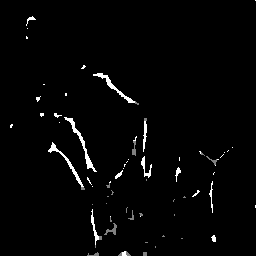

In [25]:
##Branch Detection

# Read the binary image
image1 = cv2.imread('res_gdg.png', cv2.IMREAD_GRAYSCALE)

# Threshold the image to get binary image
_, image1 = cv2.threshold(image1, 127, 255, cv2.THRESH_BINARY)

# from file 5 manuel binarized default image
image2 = binary_rp


# Define a kernel for dilation
kernel = np.ones((5,5), np.uint8)  # You can adjust the size of the kernel according to your requirement

# Dilate the image
image2 = cv2.dilate(image2, kernel, iterations=1)

# Ensure both images have the same dimensions
image2 = cv2.resize(image2, (image1.shape[1], image1.shape[0]))

# Convert images to numpy arrays
image1_np = np.array(image1, dtype=np.int16)
image2_np = np.array(image2, dtype=np.int16)

# Subtract one image from the other
result = image1_np - image2_np

# Clip negative values to zero
result = np.clip(result, 0, 255)

# Convert back to uint8
result = result.astype(np.uint8)

kernel = np.ones((3, 3), np.uint8)

# Perform erosion followed by dilation
result = cv2.erode(result, kernel, iterations=1)

#cv2.imwrite('branches_detected.png', result)
cv2_imshow(result)



Branch 1: Position (Centroid) = (255.00, 0.00), Size (Area) = 1
Branch 2: Position (Centroid) = (30.03, 19.07), Size (Area) = 29
Branch 3: Position (Centroid) = (27.00, 28.00), Size (Area) = 1
Branch 4: Position (Centroid) = (26.40, 37.20), Size (Area) = 5
Branch 5: Position (Centroid) = (83.09, 66.64), Size (Area) = 11
Branch 6: Position (Centroid) = (114.46, 87.20), Size (Area) = 188
Branch 7: Position (Centroid) = (43.50, 84.00), Size (Area) = 2
Branch 8: Position (Centroid) = (65.50, 94.00), Size (Area) = 6
Branch 9: Position (Centroid) = (37.62, 98.31), Size (Area) = 16
Branch 10: Position (Centroid) = (41.46, 114.15), Size (Area) = 13
Branch 11: Position (Centroid) = (56.47, 114.84), Size (Area) = 19
Branch 12: Position (Centroid) = (81.14, 143.49), Size (Area) = 225
Branch 13: Position (Centroid) = (144.44, 132.88), Size (Area) = 82
Branch 14: Position (Centroid) = (59.00, 122.00), Size (Area) = 1
Branch 15: Position (Centroid) = (10.89, 125.44), Size (Area) = 9
Branch 16: Posit

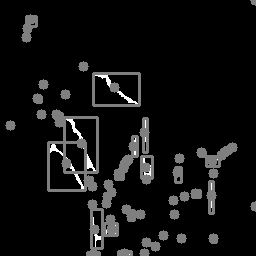

In [26]:
# Ensure the image is binary
_, binary_image = cv2.threshold(result, 127, 255, cv2.THRESH_BINARY)

# Find connected components (blobs)
num_labels, labels, stats, centroids = cv2.connectedComponentsWithStats(binary_image, connectivity=8)
totalArea=0
# Output results
for i in range(1, num_labels):  # Skip the background label 0
    x, y, w, h, area = stats[i]
    cx, cy = centroids[i]
    print(f"Branch {i}: Position (Centroid) = ({cx:.2f}, {cy:.2f}), Size (Area) = {area}")
    totalArea+=area

    # Optionally, draw rectangles and centroids on the image for visualization
    cv2.rectangle(binary_image, (x, y), (x + w, y + h), (127), 2)
    cv2.circle(binary_image, (int(cx), int(cy)), 5, (127), -1)


print(f"Total branch count is {num_labels} and total cell area is {totalArea} pixel ")
# Save the result image with drawn blobs
cv2.imwrite('res_branch_detected.png', binary_image)
cv2_imshow(binary_image)